<b><h1>IoTwins.bayesian_optimization service</h1></b>
The bayesian_optimization service developed in IoTwins is meant to support and allow clients to make hyperparameter fine-tuning.<br>This service can be used to automatically improve the performances of the already existing services as well as future services that will be developed and added in the IoTwins context. <br>
Why was this service developed? The IoTwins services are applicable in across a wide range of contexts and specifically in the area of anomaly detection.<br>
To work best, these services need specific and not always easy to find configurations that usually involve experts' work. The bayesian_optimization aims to remove this gap and allow any clients to automatically individuate the best hyperparameters configuration in an acceptable time.


The bayesian_optimization service is a wrapper of the <a href="https://github.com/hyperopt/hyperopt">Hyperopt</a> python library for serial and parallel optimization over awkward search spaces, which may include real-valued, discrete, and confitional dimensions.<br>
To conclude, the purpose of the service is to facilitate the use of the IoTwins services and make hyperparameter fine-tuning in the context of the client in the easiest and fastest manner. 

<b><h2><a href="https://archive.ics.uci.edu/ml/datasets/iris">Iris</a> Classifier optimization Example in IoTwins[bayesian_optimization service]</h2></b>
<br>
In this example, we will optimize the standard machine learning problem called the iris flowers dataset.<br>
This dataset is well studied and is a good problem for practicing on neural networks.<br>
Each instance describes the properties of an observed flower measurements and the output variable is specific iris species.<br>
Since there are more than two classes to be predicted, this is a multi-class classification problem.

Formulating an optimization problem requires four main parts, two of which completly managed from the service:<br>
    - <b>Objective Function</b>[mandatory]: takes in an input and returns a loss to minimize, so it can be a generic ML Classifier.<br>
    - <b>Domain space</b>[mandatory]: the range of input values to evaluate.<br>
    - <b>Optimization Algorithm</b>[default <a href="https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf">tpe</a>]: the method used to construct the surrogate function and choose the next values to evaluate. <b>use the default value!</b><br>
    - <b>Results</b>[not mandatory]: score, value pairs that the algorithm uses to build the model. <b>Managed by the service</b>.<br>

In [1]:
# pandas and numpy
import pandas as pd
import numpy as np
import os
# matplotlib for graphs
import matplotlib.pyplot as plt

<h5><b>Data Preperation</b></h5><br>

To prepare the data, we will simply use the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html">OneHotEncoder</a> to encode the integer features into a <a href="https://en.wikipedia.org/wiki/One-hot">One-hot</a> vector and we will use<br> a <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">StandardScaler</a> to remove the mean and scale the features to unit variance.<br>
Finally we want to perform a train test split to compare our results later on.

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.3, random_state=41)

n_features = X.shape[1]
n_classes = Y.shape[1]

<h5><b>Neural Network Model</b></h5><br>

The Model we want to fine-tuning is really simple, it requires the following parameters(as usual for every machine learning models):<br>
    - input_dim: <u>fixed</u> value to 4, the input dimensions of each sample.<br>
    - output_dim: <u>fixed</u> value to 3, the 3 different classes in our Dataset(<a href="https://en.wikipedia.org/wiki/Iris_flower_data_set">Iris</a>)<br>
    - epochs: <u>fixed</u> value to 200, as we will use the <a href="https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping"> EarlyStopping</a> Keras callback.<br>
    - verbose: <u>fixed</u> value to 0.<br>
    - validation_split: <u>fixed</u> value between 0 and 1. Fraction of the training data to be used as validation data.<br>
    <br>
    -model_params: a Python dictionary containing the information to create the model<br>
    &emsp;&emsp;&emsp; - 'n': number of hidden layers<br>
    &emsp;&emsp;&emsp; - 'nodes': number of nodes in each hidden layer<br>
    &emsp;&emsp;&emsp; - 'actv': the activation function to use in each hidden layer(<u>fixed</u> to 'relu')<br>
    &emsp;&emsp;&emsp; - 'drop_enabled': add or not a <a href="https://keras.io/api/layers/regularization_layers/dropout/">Dropout</a> layer after each hidden layer?<br>
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; - 'drop_factor': Float between 0 and 1. Fraction of the input units to drop if 'drop_enabled' is <i>True</i><br>
    &emsp;&emsp;&emsp; - 'loss': objective function(the name of the objective function) or keras.losses.Loss instance(the 'categorical_crossentropy' wil be used in this example)<br>
    &emsp;&emsp;&emsp; - 'optimizer': name of optimizer or optimizer instance(the 'adam' optimizer will be used in this example)<br>
    -batch_size: number of samples per gradient update<br>
    -shuffle: whether to shuffle the training data before each epoch<br>

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import TensorBoard, EarlyStopping
from sklearn.metrics import precision_recall_fscore_support

def create_custom_model(input_dim, output_dim, _hparams, name='model'):
    # Create model function
    model = Sequential(name=name)
    for i in range(_hparams['n']):
        model.add(Dense(_hparams['nodes'], input_dim=input_dim, activation=_hparams['actv']))
        if _hparams['drop_enabled']:
            model.add(Dropout(rate=_hparams['drop_factor']))
            
    model.add(Dense(output_dim, activation='softmax'))
    
    # Compile model
    model.compile(loss=_hparams['loss'],  # fixed ->'categorical_crossentropy', 
                  optimizer=_hparams['optimizer'],  # fixed -> 'adam', 
                  metrics=['accuracy'])
    return model


def objective_function(model_params, batch_size, shuffle, epochs, verbose, validation_split, input_dim, output_dim):
    """Objective function for the Iris Classifier"""
    stats = {}

    # TensorBoard Callback
    cb = TensorBoard()
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-5)

    model = create_custom_model(input_dim, output_dim, model_params)
    
    history_callback = model.fit(X_train, Y_train,
                                batch_size=batch_size,
                                shuffle=True,
                                epochs=epochs,
                                verbose=verbose,
                                validation_split=validation_split,
                                callbacks=[cb, early_stopping])
    score = model.evaluate(X_test, Y_test, verbose=0)
    
    stats['test_loss'] = score[0]
    stats['test_accuracy'] = score[1]
    
    Y_pred = model.predict(X_test)
    # from array of probabilities to array of 0-1
    # [0.872312,0.114322,0,013366] --> [1,0,0]
    for i,el in enumerate(Y_pred):
        i_max = int(np.argmax(Y_pred[i]))
        Y_pred[i].fill(0)
        Y_pred[i][i_max] = 1
    precision_W, recall_W, fscore_W, xyz = precision_recall_fscore_support(Y_test, Y_pred, average='weighted')
    stats['precision_W'] = precision_W
    stats['recall_W'] = recall_W
    stats['fscore_W'] = fscore_W
    
    score = score[0]  # we wnto to minimize the test loss
    return score, stats, {'model': model, 'history': history_callback}  # mandatory return format

Using TensorFlow backend.


<b>Domain Space</b><br>
The domain space is the input values over which we want to search.<br>
This part may be the most difficult part to handle, however the bayesian_optimization service<br>
require the same space domain format as for the Hyperopt(<a href="http://hyperopt.github.io/hyperopt/getting-started/search_spaces/">How to define a Search Space</a>).<br>
<br>
Sometimes may be needed to pass fixed paramters to the objective function, parameters which are not part of the search space.<br>
This can be done passing a dict to the <i>"others_params"</i> bayesian_optimiztion's parameter.<br>
<br>
In our example we have 9 parameters in which 6 to be fine-tuned(see the <i>s</i> dictionary) and 5 fixed parameters(see the <i>o_p</i> dictionary).<br>
Within the domain space, we also have 3 fixed parameters(<i>'actv'</i>, <i>'loss'</i> and <i>'optimizer'</i>) because at each evaluation/iteration the space instance will always be stored in the csv file and we want to keep track of it.<br>
<br>
The domain instance will be passed to the <i>space_func_process</i> function if specified otherwise it will directly passed to the objective function. In the case the <i>space_func_process</i> is specified, its output will be passed.<br>
Instead, the fixed parameters instance is always directly passed to the objective function(<i>epochs</i>, <i>validation_split</i>, <i>verbose</i>, <i>input_dim</i>, <i>output_dim</i>).


In [4]:
from hyperopt import hp
# Domain Space
s = {
    'batch_size': hp.quniform('batch_size', 1, 16, 1),
    'shuffle': hp.choice('shuffle', [True, False]),
    'drop_enabled': hp.choice('drop_enabled',
                            [{'drop_enabled': True, 'drop_factor': hp.quniform('drop_factor', 0.1, 0.9, 0.1)},
                             {'drop_enabled': False, 'drop_factor': 0.1}]),
    'n': hp.quniform('n', 1, 12, 1),
    'nodes': hp.quniform('nodes', 1, 24, 2),
    'actv': 'relu',
    'loss': 'categorical_crossentropy',
    'optimizer': 'adam'
    }

# Fixed Parameters
o_p = {'epochs': 200, 'validation_split': 0.15, 'verbose': 0, 'input_dim': 4, 'output_dim': 3} 

Since the output of the 'space_func_process' function is passed to the objective function, we will use the <i>'s_f_p'</i> function to adjust/modify each given space instance. So with this function <b>we can round or cast values, we can also format the dictionary as the objective function expect it</b>(no second level dictionary - just one level!, parameters assigned to the <i>'model_params'</i> key, etc...).

In [5]:
"""
Every iteration the bayesian_optimization service chooses the new hyperparameters for their evaluation accordingly 
to the distributions specified in s. If a 'space_func_process' function is specified, the service passes those 
hyperparameters to it and its output will be passed to the objective function(the classifier in this case).

So with this function we can round, cast values or format the dictionary as the objective function expect it.
"""
def s_f_p(params):
    drop_factor = params['drop_enabled'].get('drop_factor', 0.1)
    
    params['n'] = int(params['n'])
    params['nodes'] = int(params['nodes'])
    # Extract the drop_enabled
    params['drop_enabled'] = params['drop_enabled']['drop_enabled']  # no second level dictionary, 'drop_factor' moved to the first level toghether with 'drop_enabled'
    params['drop_factor'] = round(drop_factor,2)
    
    batch_size = int(params['batch_size'])  # int(params.pop('batch_size'))
    shuffle = params['shuffle']  # params.pop('shuffle')
    
    # the returned dictionary partially corresponds to the input of the objective function
    # what is missing is present in the dictionary of fixed parameters(o_p: epochs, verbose, validation_split, input_dim, output_dim)
    return {'model_params': params, 'batch_size':batch_size, 'shuffle':shuffle}  # this output will be passed to the objective function

<b><h3>Optimization</h3></b><br>
Now that the problem is defined, we can minimize our objective function!<br>
To do so, we use the <i>bayesian_optimization</i> service that takes the four parts above, as well as a maximum number of evaluations:

In [6]:
from servises.bayesian_optimization.src.bayesianOptimization import bayesian_optimization  # import the service

out_file = "iris_classifier_trials.csv"  # output file name of the csv file in which will be stored the <score, parameters, stats, iteration>
t_e = 50  # total_evals
s_t_e = None  # save_trial_every
'''
best, trial_fname = bayesian_optimization(function_to_optimize=objective_function, space_func_process=s_f_p, 
                                          trial_fname=out_file, space=s, total_evals=t_e, 
                                          save_model_func=None, others_params=o_p)
'''
# Instead of running the optimization here(in a jupyter notebook) I runned the .py example version(Example3_iris_classifier_bo.py)
trial_fname = "servises/bayesian_optimization/out/run/example3/trials_50_default_0.0.p"
print("\n\ntrial_fname: {}".format(trial_fname))
# print("BEST parameter/s:")
# print(best)



trial_fname: servises/bayesian_optimization/out/run/example3/trials_50_default_0.0.p


In [7]:
from servises.bayesian_optimization.src.bayesianOptimization import _load_trials

def print_best_trials_results(t_fname, best_numb=3):
    # Sort the trials with lowest loss first and print the best 3 ones
    best_numb = 3
    trial_filename, _ = os.path.splitext(t_fname)
    tpe_trials = _load_trials(trial_filename)
    bayes_trials_results = sorted(tpe_trials.results, key=lambda x: x['loss'])

    for i,record in enumerate(bayes_trials_results[:best_numb]):
        print("||--- {}# ---||".format(i+1))
        for e in record:
            print("{} -> {}".format(e, record[e]))
        print("\n")

print_best_trials_results(trial_fname)

[BO] trial loaded
||--- 1# ---||
loss -> 0.13139736784829034
params -> {'model_params': {'actv': 'relu', 'batch_size': 16.0, 'drop_enabled': False, 'loss': 'categorical_crossentropy', 'n': 4, 'nodes': 8, 'optimizer': 'adam', 'shuffle': False, 'drop_factor': 0.1}, 'batch_size': 16, 'shuffle': False}
stats -> {'test_loss': 0.13139736784829034, 'test_accuracy': 0.933333334657881, 'precision_W': 0.9346405228758171, 'recall_W': 0.9333333333333333, 'fscore_W': 0.9333910533910534}
iteration -> 39
train_time -> 69.79489699999999
status -> ok


||--- 2# ---||
loss -> 0.14266662001609803
params -> {'model_params': {'actv': 'relu', 'batch_size': 15.0, 'drop_enabled': False, 'loss': 'categorical_crossentropy', 'n': 5, 'nodes': 4, 'optimizer': 'adam', 'shuffle': False, 'drop_factor': 0.1}, 'batch_size': 15, 'shuffle': False}
stats -> {'test_loss': 0.14266662001609803, 'test_accuracy': 0.9111111124356588, 'precision_W': 0.9111111111111111, 'recall_W': 0.9111111111111111, 'fscore_W': 0.91111111111111

At the end of the service's execution we'll have the <i>iris_classifier_trials.csv</i> and the Trials file <i>trials_10_default_0.0.p</i> in the <i>/out</i> folder.<br>
As seen in the first example, we can use the Trials file to "continue" the bayesian optimization starting from the 50th evaluation and not again from the beginning.

Once the run of evaluations is completed if we would like to use that model for others purposes we need to train again a model because we never didn't save anything during the optimization process.<br>
<br>
This is not so smart and a waste of time, so let's implement a function for saving our model during the optimization process.

In [8]:
# this function takes in, as input, the output of the objective function so:
# model_name, best_score, stats and the third "custom" python dictionary(in our case, the keras model and the history callback)
from servises.bayesian_optimization.src.bayesianOptimization import trained_models_dir
def save_model_function(model_name, best_score, stats, model, history):
    model_name_ext = '{}/{}.h5'.format(trained_models_dir, model_name)
    model.save(model_name_ext)   # I want to save just the model(.h5 format) inside the 'trained_models' folder without take into consideration the history object
    return True  # it can return whatever we want

In [9]:
# remove the entrire path and the extension to get the name of the stored Trials file
trial_filename, _ = os.path.splitext(trial_fname)
trial_filename = trial_filename.split('/')[-1]

s_t_e = 50  # save_trial_every
# we run 150 more evaluations/iterations and we save the Trials python object every 50 iterations
'''
new_best, new_trial_fname = bayesian_optimization(function_to_optimize=objective_function, space_func_process=s_f_p, 
                                                  trial_fname=out_file, space=s, total_evals=t_e+150, save_trial_every=s_t_e,
                                                  save_model_func=save_model_function, others_params=o_p, trials_name=trial_filename)
'''
# Instead of running the optimization here(in a jupyter notebook) I runned the .py example version(Example3_iris_classifier_bo.py)
new_trial_fname = "servises/bayesian_optimization/out/run/example3/trials_200_default_0.0.p"
print("\n\ntrial_fname: {}".format(new_trial_fname))
# print("BEST parameter/s:")
# print(new_best)



trial_fname: servises/bayesian_optimization/out/run/example3/trials_200_default_0.0.p


In [10]:
new_trial_fname = "servises/bayesian_optimization/out/run/example3/trials_200_default_0.0.p"
print_best_trials_results(new_trial_fname)

[BO] trial loaded
||--- 1# ---||
loss -> 0.13139736784829034
params -> {'model_params': {'actv': 'relu', 'batch_size': 16.0, 'drop_enabled': False, 'loss': 'categorical_crossentropy', 'n': 4, 'nodes': 8, 'optimizer': 'adam', 'shuffle': False, 'drop_factor': 0.1}, 'batch_size': 16, 'shuffle': False}
stats -> {'test_loss': 0.13139736784829034, 'test_accuracy': 0.933333334657881, 'precision_W': 0.9346405228758171, 'recall_W': 0.9333333333333333, 'fscore_W': 0.9333910533910534}
iteration -> 39
train_time -> 69.79489699999999
status -> ok


||--- 2# ---||
loss -> 0.14266662001609803
params -> {'model_params': {'actv': 'relu', 'batch_size': 15.0, 'drop_enabled': False, 'loss': 'categorical_crossentropy', 'n': 5, 'nodes': 4, 'optimizer': 'adam', 'shuffle': False, 'drop_factor': 0.1}, 'batch_size': 15, 'shuffle': False}
stats -> {'test_loss': 0.14266662001609803, 'test_accuracy': 0.9111111124356588, 'precision_W': 0.9111111111111111, 'recall_W': 0.9111111111111111, 'fscore_W': 0.91111111111111

Once the second run of evaluations is completed we got a better hyperparameters configuration and its correspondent model has been saved, so we can directly load it and use as we want.

<b><h3>Visualize the Results</h3></b><br>
Let's plot some graphs to better understand the hyperparameters' distributions really used in the 150 iterations/evaluations.

In [11]:
import os
t_fname = 'servises/bayesian_optimization/out/run/example3/trials_200_default_0.0.p'
trial_filename, _ = os.path.splitext(t_fname)
print(trial_filename)

tpe_trials = _load_trials(trial_filename)

tpe_results = pd.DataFrame({'loss': [x['loss'] for x in tpe_trials.results],
                            'iteration': [x['iteration'] for x in tpe_trials.results],
                            'n': [x['params']['model_params']['n'] for x in tpe_trials.results],
                            'nodes': [x['params']['model_params']['nodes'] for x in tpe_trials.results],
                            'batch_size': [x['params']['batch_size'] for x in tpe_trials.results],
                            'drop_enabled': [x['params']['model_params']['drop_enabled'] for x in tpe_trials.results],
                            'drop_factor': [x['params']['model_params']['drop_factor'] for x in tpe_trials.results],
                            'shuffle': [x['params']['shuffle'] for x in tpe_trials.results]
                           })


tpe_results

servises/bayesian_optimization/out/run/example3/trials_200_default_0.0
[BO] trial loaded


,loss,iteration,n,nodes,batch_size,drop_enabled,drop_factor,shuffle
0,0.566330,0,4,10,14,False,0.1,False
1,0.176483,1,3,4,15,False,0.1,False
2,1.108569,2,7,24,7,True,0.6,True
3,0.391424,3,2,18,14,True,0.7,True
4,0.437130,4,8,14,4,False,0.1,False
...,...,...,...,...,...,...,...,...
195,0.886789,195,7,14,13,False,0.1,False
196,0.371104,196,8,4,16,False,0.1,False
197,0.328338,197,5,6,14,False,0.1,False
198,0.278392,198,1,8,15,False,0.1,True


--- n: Number of hidden layers ---<br>
Concentration of the tested values between <b>4-5</b>

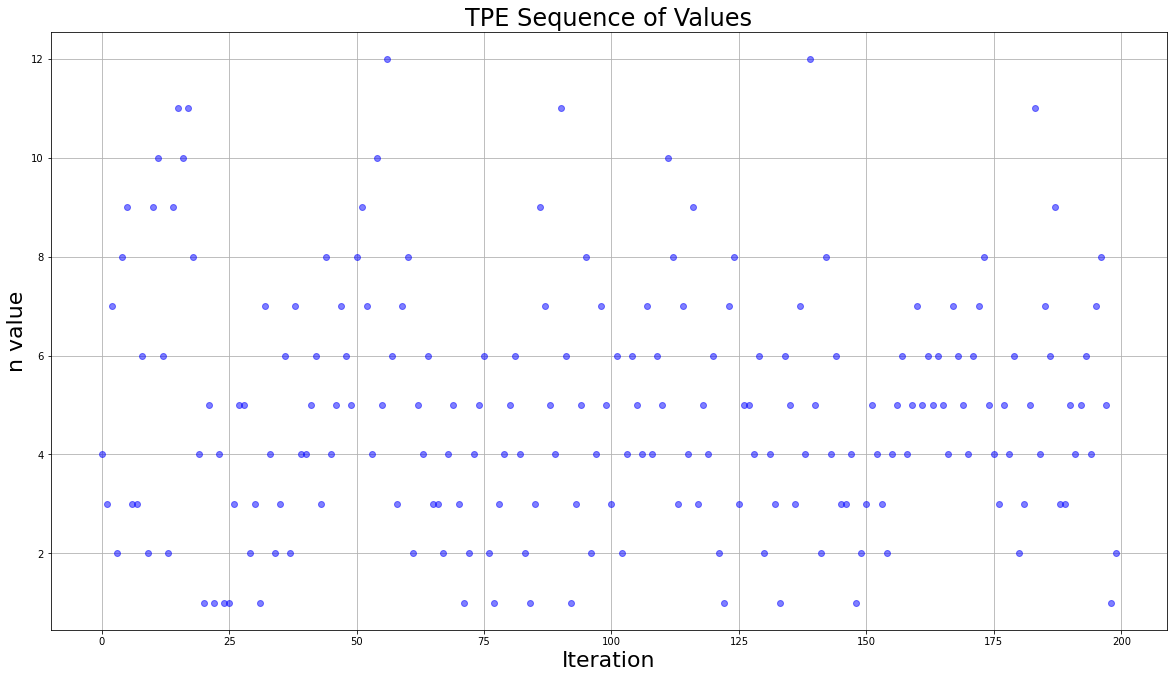

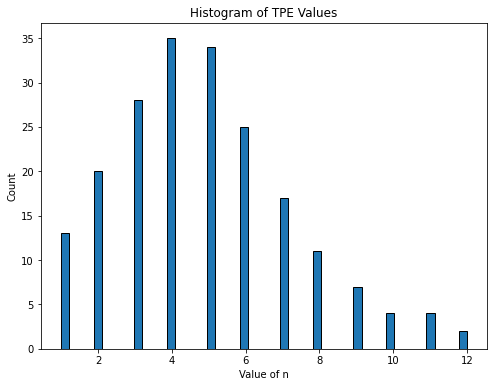

In [12]:
# --- n: Number of hidden layers ---
# Print the TPE Sequence of Values
plt.figure(figsize = (20, 11))
plt.plot(tpe_results['iteration'], tpe_results['n'],  'bo', alpha = 0.5);
plt.xlabel('Iteration', size = 22); plt.ylabel('n value', size = 22); plt.title('TPE Sequence of Values', size = 24);
#plt.hlines(1, 0, 5000, linestyles = '--', colors = 'r');
plt.grid();

# Print the Histogram of TPE Values
plt.figure(figsize = (8, 6))
plt.hist(tpe_results['n'], bins = 50, edgecolor = 'k');
plt.title('Histogram of TPE Values'); plt.xlabel('Value of n'); plt.ylabel('Count');

--- nodes: Number of nodes in each hidden layer ---<br>
Concentration of the tested values between <b>4-8</b>

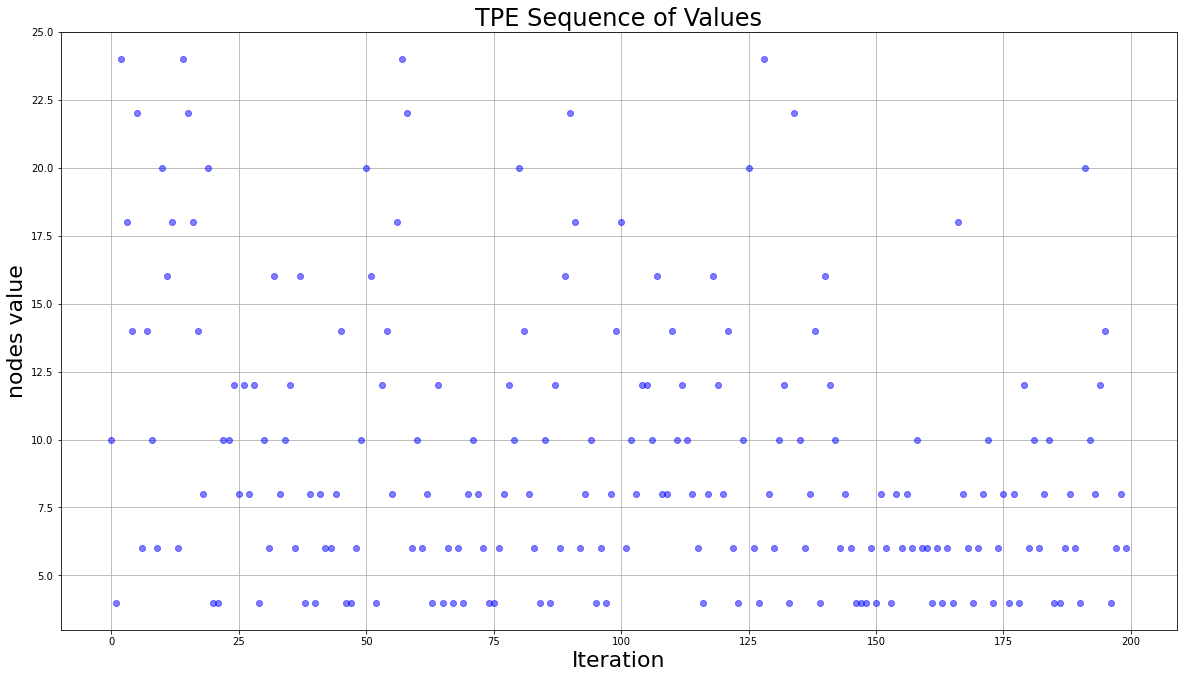

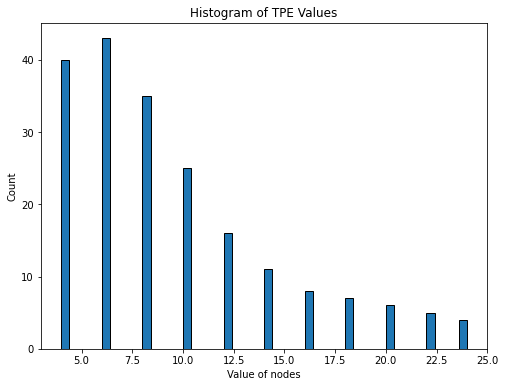

In [13]:
# --- nodes: Number of nodes in each hidden layer ---
# Print the TPE Sequence of Values
plt.figure(figsize = (20, 11))
plt.plot(tpe_results['iteration'], tpe_results['nodes'],  'bo', alpha = 0.5);
plt.xlabel('Iteration', size = 22); plt.ylabel('nodes value', size = 22); plt.title('TPE Sequence of Values', size = 24);
#plt.hlines(1, 0, 5000, linestyles = '--', colors = 'r');
plt.grid();

# Print the Histogram of TPE Values
plt.figure(figsize = (8, 6))
plt.hist(tpe_results['nodes'], bins = 50, edgecolor = 'k');
plt.title('Histogram of TPE Values'); plt.xlabel('Value of nodes'); plt.ylabel('Count');

--- shuffle: whether to shuffle the training data before each epoch ---<br>
the 81,5% of time shuffle=False.

False    163
True      37
Name: shuffle, dtype: int64


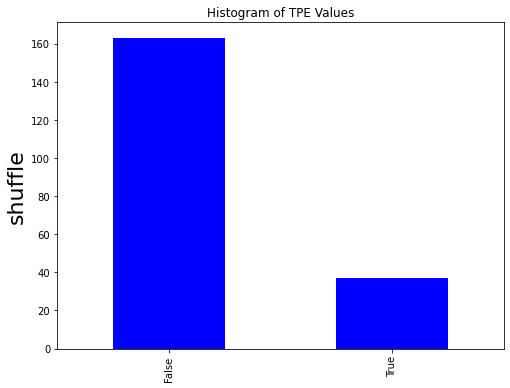

In [14]:
# Bar plots of shuffle
print(tpe_results['shuffle'].value_counts())
tpe_results['shuffle'].value_counts().plot.bar(figsize = (8, 6), color = 'blue', title = 'Histogram of TPE Values')
plt.ylabel('shuffle', size = 22);
#plt.hist(tpe_results['shuffle'], bins = 2, edgecolor = 'k');
#plt.title('Histogram of TPE Values'); plt.xlabel('Value of shuffle'); plt.ylabel('Count');

--- batch_size: number of samples per gradient update ---<br>
Concentration of the tested values between <b>14-16</b>

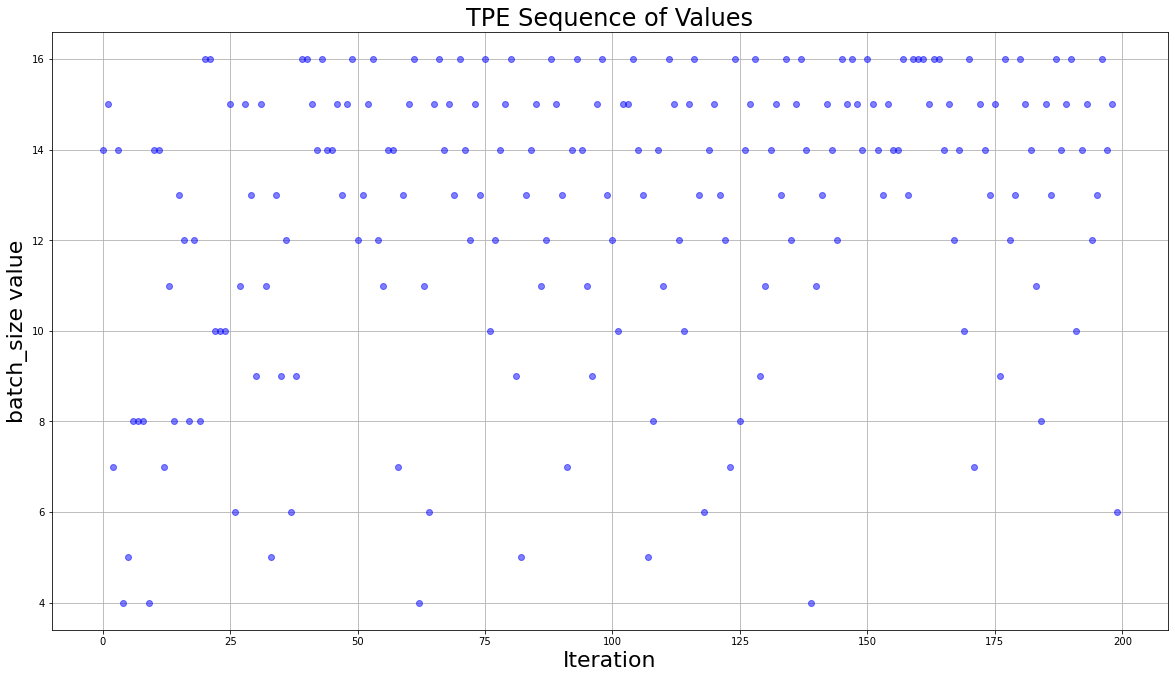

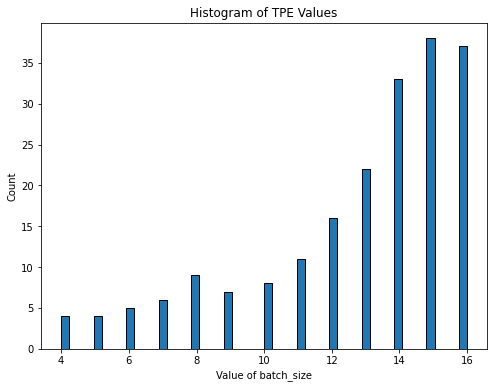

In [15]:
# --- batch_size: number of samples per gradient update ---
# Print the TPE Sequence of Values
plt.figure(figsize = (20, 11))
plt.plot(tpe_results['iteration'], tpe_results['batch_size'],  'bo', alpha = 0.5);
plt.xlabel('Iteration', size = 22); plt.ylabel('batch_size value', size = 22); plt.title('TPE Sequence of Values', size = 24);
#plt.hlines(1, 0, 5000, linestyles = '--', colors = 'r');
plt.grid();

# Print the Histogram of TPE Values
plt.figure(figsize = (8, 6))
plt.hist(tpe_results['batch_size'], bins = 50, edgecolor = 'k');
plt.title('Histogram of TPE Values'); plt.xlabel('Value of batch_size'); plt.ylabel('Count');

--- drop_enabled: add or not a Dropout layer after each hidden layer? ---<br>
the 82% of time drop_enabled=False.

False    164
True      36
Name: drop_enabled, dtype: int64


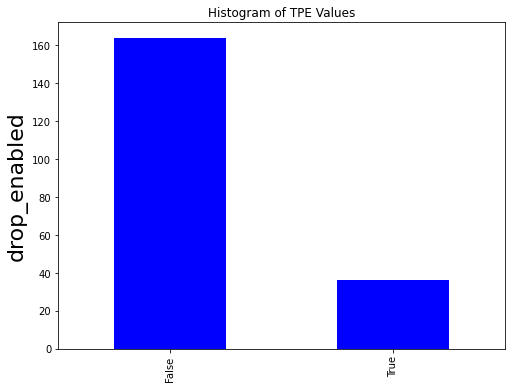

In [16]:
# Bar plots of drop_enabled
print(tpe_results['drop_enabled'].value_counts())
tpe_results['drop_enabled'].value_counts().plot.bar(figsize = (8, 6), color = 'blue', title = 'Histogram of TPE Values')
plt.ylabel('drop_enabled', size = 22);

<b><h2>Conclusions</h2></b>

<h4>Conclusion</h4>
What can we say in conclusion?<br>
We can say that it is convenient to choose the values of the hyperparameters among the following ranges:<br>
    &emsp;&emsp;&emsp; - 'n': <b>[4 - 5]</b><br>
    &emsp;&emsp;&emsp; - 'nodes': <b>[4 - 8]</b><br>
    &emsp;&emsp;&emsp; - 'batch_size': <b>[14 - 16]</b><br>
    &emsp;&emsp;&emsp; - 'shuffle': <b>False</b><br>
    &emsp;&emsp;&emsp; - 'drop_enabled': <b>False</b>

<h5>References & Credits</h5>
<a href="https://janakiev.com/blog/keras-iris/">Classifying the Iris Data Set with Keras</a><br>
<a href="https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/">Multi-Class Classification Tutorial with the Keras Deep Learning Library</a>